In [ ]:
import pandas as pd
import json
import os
import matplotlib as mpl
from matplotlib import pyplot as plt
import requests
from io import StringIO as sio
from matplotlib.patches import Patch
import matplotlib.ticker as ticker
import itertools
import re
import sys
import pprint
import statistics

module_dir = "./scripts/"
sys.path.append(module_dir)

import balticEdited as bt
# import reassortment_rates_host as rea
import reassortment_utils as rea

#use treesort_prepper to prep files and run treesort

#run before_plotting on treesort trees so then it is ready for plotting with baltic


In [ ]:
def load_tree(path,filename,region_dict, host_dict):
    nwkPath=f"{path}/{filename}"
    mytree = bt.loadNewick(nwkPath, absoluteTime= False)
    mytree = traits(mytree, region_dict, host_dict)
    return(mytree)


def load_clock(blength_file):

    with open(blength_file) as f:
        data = json.load(f)

    rate = data["clock"]["rate"]
    
    return rate

def load_trait_data(traits_file):

    with open(traits_file) as f:
        data = json.load(f)
    
    region_dict = {}
    host_dict = {}

    for node_name, node_data in data['nodes'].items():
        region_dict[node_name] = node_data.get("region")
        host_dict[node_name] = node_data.get("host")

    return(region_dict, host_dict)

def traits(tree, region_dict, host_dict):
    
    for k in tree.Objects:
        if k.branchType == "node":
            k.traits["region"] = region_dict.get(k.traits["label"])
            k.traits["host"] = host_dict.get(k.traits["label"])
        if k.branchType == "leaf":
            k.traits["region"] = region_dict.get(k.name)
            k.traits["host"] = host_dict.get(k.name)
    return(tree)


region_colors = {
    'Europe': '#9e0142',
    'Japan Korea': '#d53e4f',
    'Southeast Asia': '#f46d43',
    'West Asia': '#fdae61',
    'South America': '#fee08b',
    'South Asia' : '#e6f598',
    'Africa': '#abdda4',
    'China': '#66c2a5',
    'Oceania': '#3288bd',
    'North America': '#5e4fa2'
}

host_colors = {
    'Avian': '#d53e4f',
    'Camel': '#f46d43',
    'Equine': '#fdae61',
    'Feline': '#fee08b',
    'Seal': '#f7f7b2',
    'Canine': '#e6f598',
    'Human': '#abf0a4',
    'Mink': '#66c2a5',
    'Swine': '#3288bd'
}



In [ ]:
ref = "mp"
path = './trees_1'
filename = 'for_plotting.nwk'
region_dict, host_dict = load_trait_data(f"{path}/traits_1/traits_h3nx_{ref}.json")
clock_rate = load_clock(f"./preprepped/branch-lengths_h3nx_{ref}.json")
mytree = load_tree(path, filename, region_dict, host_dict)

if not os.path.exists("plots"):
    os.makedirs("plots")
else:
    pass

In [ ]:
def plot_region(mytree, output_path, fig_name):

    fig, ax = plt.subplots(figsize=(15, 15))

    x_attr = lambda k: k.x
    
    color_by = lambda k: region_colors.get(k.traits['region'])

    func_width = lambda k: 5 if k.traits['is_reassorted'] else 2.5 #ha

    mytree.plotTree(ax, x_attr=x_attr,colour="darkgrey", width = func_width)
    
    def s_func_x(k):
        
        mapping = {
            True: 250,
            False: 0
        }

        return mapping[k.traits['is_reassorted']]

    def s_func_o(k):
        
        mapping = {
            True: 0,
            False: 50
        }
        
        return mapping[k.traits['is_reassorted']]
    
    mytree.plotPoints(ax,
                   x_attr=x_attr,
                   size=s_func_o,
                   colour=color_by,
                   outline_colour='#3f3f3f',
                   zorder=3,
                   marker='o'
                     )

    mytree.plotPoints(ax,
                   x_attr=x_attr,
                   size=s_func_x,
                   colour=color_by,
                   outline=False,
                   zorder=4,
                   marker='X',
                   edgecolor='#3f3f3f'
                     )
    

    legend_handles = [Patch(color=color, label=region) for region, color in region_colors.items()]

    legend = ax.legend(handles=legend_handles, title="$\\bf{Regions}$", loc="lower left", fontsize='22')
    plt.setp(legend.get_title(),fontsize='23')
    
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    ax.set_yticks([])
    ax.set_yticklabels([])
    [ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
    ax.tick_params(axis='x',labelsize=25,size=15, width=2,color='grey')
    fig.tight_layout()
    
    
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    else:
        pass
    
    plt.savefig(f"{output_path}/{fig_name}")
    plt.show()

In [ ]:
def plot_host(mytree, output_path, fig_name):
    
    plt.rcParams["font.family"] = "Arial"

    fig, ax = plt.subplots(figsize=(15, 15))

    x_attr = lambda k: k.x
    
    color_by = lambda k: 'red' if k.traits['host'] == 'ancestor' else host_colors.get(k.traits['host'])

    mytree.plotTree(ax, x_attr=x_attr,colour=color_by, width = 3)
    
    mytree.plotPoints(ax,
                   x_attr=x_attr,
                   size=100,
                   colour=color_by,
                   outline_colour='#3f3f3f',
                   zorder=3,
                   marker='o',
                   edgecolor='#3f3f3f'
                     )

    legend_handles = [Patch(color=color, label=host) for host, color in host_colors.items()]

    legend = ax.legend(handles=legend_handles, title="$\\bf{Hosts}$", loc="lower left", fontsize='25')
    plt.setp(legend.get_title(),fontsize=25)
    
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    ax.set_yticks([])
    ax.set_yticklabels([])
    [ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
    ax.tick_params(axis='x',labelsize=25,size=15, width=2,color='grey')
    ax.set_xlabel("Divergence", fontsize=25, fontweight="bold")
    fig.tight_layout()
    
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    else:
        pass
    
    
    plt.savefig(f"{output_path}/{fig_name}")
    plt.show()

In [ ]:
def plot_host_reassort(mytree, output_path, fig_name):

    fig, ax = plt.subplots(figsize=(15, 15))

    x_attr = lambda k: k.x
    
    color_by = lambda k: 'red' if k.traits['host'] == 'ancestor' else host_colors.get(k.traits['host'])
    
    func_width = lambda k: 7 if k.traits['is_reassorted'] else 3 #ha

    # func_width = lambda k: 10 if k.traits['is_reassorted'] else 2 #na

    mytree.plotTree(ax, x_attr=x_attr,colour=color_by, width = func_width)
    
    def s_func_x(k):
        
        mapping = {
            True: 250,
            False: 0
        }

        return mapping[k.traits['is_reassorted']]

    def s_func_o(k):
        
        mapping = {
            True: 0,
            False: 50
        }
        
        return mapping[k.traits['is_reassorted']]
    
    mytree.plotPoints(ax,
                   x_attr=x_attr,
                   size=s_func_o,
                   colour=color_by,
                   outline_colour='#3f3f3f',
                   zorder=3,
                   marker='o'
                     )

    mytree.plotPoints(ax,
                   x_attr=x_attr,
                   size=s_func_x,
                   colour=color_by,
                   zorder=4,
                   marker='X',
                   outline=False,
                   edgecolor='#3f3f3f'
                     )

    # target_func = lambda k: k.is_leaf() or k.is_node()  # Which branches will be annotated
    # text_func = lambda k: k.traits['rea'] if k.traits['is_reassorted'] else ""

    # mytree.addText(ax, x_attr=x_attr, target=target_func, text=text_func, size = '15')

    legend_handles = [Patch(color=color, label=host) for host, color in host_colors.items()]

    legend = ax.legend(handles=legend_handles, title="$\\bf{Hosts}$", loc="lower left", fontsize='25')
    plt.setp(legend.get_title(),fontsize=25)
    
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    ax.set_yticks([])
    ax.set_yticklabels([])
    [ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
    ax.tick_params(axis='x',labelsize=25,size=15, width=2,color='grey')
    fig.tight_layout()
    
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    else:
        pass
    
    plt.savefig(f"{output_path}/{fig_name}")
    
    plt.show()

In [ ]:
plot_region(mytree, "plots/whole_tree", "treesort_region.pdf")

In [ ]:
plot_host(mytree, "plots/whole_tree", "host_only.pdf")

In [ ]:
plot_host_reassort(mytree, "plots/whole_tree", "treesort_host.pdf")

In [ ]:
est1 = rea.compute_rea_rate_simple(mytree, clock_rate, ignore_top_edges=1)
est2 = rea.compute_rea_rate_binary_mle(mytree, clock_rate, 1700)

In [ ]:
print(est1,est2)

In [ ]:
def host_subtrees(mytree, traitName, host_order, min_leaves, host_dict):
    
    mytree.root.traits[traitName]='ancestor' ## give root node some trait value that's different from what the actual tree root has, so it registers as a switch

    host_trees={host:[] for host in host_order}

    for k in sorted(mytree.Objects,key=lambda x:x.height):
        kp=k.parent     # kp is the parent node of k

        # get current node's (k) and its parent's (kp) trait states
        kloc=k.traits[traitName]   # kloc = trait of k; kc = trait of k; they are the same thing
        if traitName in k.parent.traits:  # if parent has a trait block, use that trait, else assign to ancestor
            kploc=kp.traits[traitName]     # kploc = trait of parental node
        else:
            kploc='ancestor'
        
        # print(k.traits)
        # print(f"kploc = {kploc}")
        # print(f"kloc = {kloc}") 

        # if states do not match
        if kloc!= "ancestor" and kloc != kploc:      # if node and parental node do not have the same trait
            #N_children=len(k.leaves)
            traverse_condition=lambda w:w.traits[traitName]==kloc     # traverse tree for all nodes whose traitname = kc
            # print('subtree resulting from '+kploc+' > '+kloc+' switch, traversing within '+ kloc)

            subtree=mytree.subtree(k,traverse_condition=traverse_condition) ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state

            if subtree != None:
                clade_leaves = [leaf for leaf in subtree.getExternal() if host_dict.get(leaf.name) == kloc]
                if len(clade_leaves) >= min_leaves:
                    subtree.traverse_tree()
                    subtree.sortBranches()
                    host_trees[kloc].append((kploc,subtree))
                    
    return(host_trees)

In [ ]:
host_order = ['Avian', 'Canine','Swine', 'Human', 'Mink', 'Seal', 'Equine', 'Camel', 'Feline']

host_trees = host_subtrees(mytree, "host", host_order, 10, host_dict)

print(host_trees)

for s in host_trees: 
    print(s)
    print(len(host_trees[s]))

In [ ]:
hosts_est1, hosts_est2, subtree_rates_simple, subtree_rates_mle = rea.host_reassortments(host_trees, host_order, clock_rate, 1700)

In [ ]:
print(hosts_est1)
print(hosts_est2)

In [ ]:
def store_subtree_nodes(host_trees, host):
    
    subtree_nodes = set()

    subtrees = host_trees[host]
    for kploc, subtree in subtrees:
        
        if host == "Canine" and kploc == "Equine":
            continue
        
        for k in subtree.Objects:
            if k.is_node():
                subtree_nodes.add(k.traits['label'])
            if k.is_leaf():
                subtree_nodes.add(k.name)
    return subtree_nodes

def plot_host_trees_time(mytree, host_trees, target_host, output_path):
    
    host_counts = {host: 0 for host in target_host}
    
    for host in target_host:
        if len(host_trees[host]) != 0:
        
            fig, ax = plt.subplots(figsize=(15, 15))

            subtree_nodes = store_subtree_nodes(host_trees, host)

            def subtree_coloring(k):

                if ((k.is_leaf() and k.name in subtree_nodes) or (k.is_node() and k.traits['label'] in subtree_nodes)) and k.traits['host'] == host:

                    region = k.traits.get("region")
                    return region_colors.get(region)  #for host with region data
                else:
                    return 'darkgrey'

            def subtree_labeling(k):
                if (k.is_leaf() and k.name in subtree_nodes) or (k.is_node() and k.traits['label'] in subtree_nodes):
                    if k.traits.get('is_reassorted') and k.traits['host'] == host:
                        return k.traits["rea"]
                return '' 
            
            
            func_width = lambda k: 5 if k.traits['is_reassorted'] else 2.5 #ha
            x_attr = lambda k: k.x
            color_by = lambda k: subtree_coloring(k)
            mytree.plotTree(ax, x_attr=x_attr,colour="darkgrey", width = func_width)

            def s_func_x(k):

                mapping = {
                    True: 200,
                    False: 0
                }

                if ((k.is_leaf() and k.name in subtree_nodes) or (k.is_node() and k.traits['label'] in subtree_nodes)) and k.traits['host'] == host: 
                    return mapping[k.traits['is_reassorted']]

                else:
                    return(0)

            def s_func_o(k):

                mapping = {
                    True: 0,
                    False: 70
                }

                if ((k.is_leaf() and k.name in subtree_nodes) or (k.is_node() and k.traits['label'] in subtree_nodes)) and k.traits['host'] == host: 
                    return mapping[k.traits['is_reassorted']]

                else:
                    return(30)


            mytree.plotPoints(ax,
                           x_attr=x_attr,
                           size=s_func_o,
                           colour=color_by,
                           outline_colour='#3f3f3f',
                           zorder=3,
                           marker='o'
                             )

            mytree.plotPoints(ax,
                           x_attr=x_attr,
                           size=s_func_x,
                           colour=color_by,
                           outline=False,
                           zorder=4,
                           marker='X',
                           edgecolor='#3f3f3f'
                             )
            
            legend_handles = [Patch(color=color, label=region) for region, color in region_colors.items()]
            
            legend_title = (f"$\\bf{{{host}}}$\n"
                f"$\\bf{{Reassortment}}$\n"
                f"$\\bf{{rate:}}$ {hosts_est2[host]:.4f}")

            legend = ax.legend(handles=legend_handles, title= legend_title, title_fontsize='x-large', loc="lower left", fontsize='x-large')

            ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

            ax.set_yticks([])
            ax.set_yticklabels([])
            [ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
            ax.tick_params(axis='x', labelsize=20, size=15, width=2, color='grey')
            
            if not os.path.exists(output_path):
                os.makedirs(output_path)
            else:
                pass

            plt.savefig(f"{output_path}/{host}_tree_regions.pdf")
            plt.show()


In [ ]:
target_host = ['Avian', 'Swine', 'Canine', 'Human', 'Mink', 'Seal', 'Equine', 'Camel', 'Feline']

plot_host_trees_time(mytree, host_trees, target_host, "plots/host_trees")

In [ ]:
def plot_single_subtree(subtree, host, output_path, fig_name):
    
    fig, ax = plt.subplots(figsize=(15, 15), facecolor='w')
    
    subtree_nodes = {k.traits['label'] if k.is_node() else k.name for k in subtree.Objects}
    
    def subtree_coloring(k):
        if ((k.is_leaf() and k.name in subtree_nodes) or 
            (k.is_node() and k.traits['label'] in subtree_nodes)) and k.traits['host'] == host:
            return region_colors.get(k.traits['region'])
        else:
            return 'darkgrey'

    def subtree_labeling(k):
        if ((k.is_leaf() and k.name in subtree_nodes) or 
            (k.is_node() and k.traits['label'] in subtree_nodes)) and k.traits.get('is_reassorted'):
            return k.traits["rea"]
        return ''
    
    func_width = lambda k: 5 if k.traits['is_reassorted'] else 2.5 #ha
    x_attr = lambda k: k.x
    color_by = lambda k: subtree_coloring(k)
    subtree.plotTree(ax, x_attr=x_attr,colour="darkgrey", width = func_width)

    def s_func_x(k):

        mapping = {
            True: 250,
            False: 0
        }

        return mapping[k.traits['is_reassorted']]

    def s_func_o(k):

        mapping = {
            True: 0,
            False: 50
        }

        return mapping[k.traits['is_reassorted']]

    subtree.plotPoints(ax,
                   x_attr=x_attr,
                   size=s_func_o,
                   colour=color_by,
                   outline_colour='#3f3f3f',
                   zorder=3,
                   marker='o'
                     )

    subtree.plotPoints(ax,
                   x_attr=x_attr,
                   size=s_func_x,
                   colour=color_by,
                   outline=False,
                   zorder=4,
                   marker='X',
                   edgecolor='#3f3f3f'
                     )

    
    legend_handles = [Patch(color=color, label=region) for region, color in region_colors.items()]
    
    legend_title = (f"$\\bf{{{host}}}$\n"
                f"$\\bf{{Reassortment}}$\n"
                f"$\\bf{{rate:}}$ {hosts_est2[host]:.4f}")
    
    legend = ax.legend(handles=legend_handles, title = legend_title, title_fontsize='x-large', loc="lower left", fontsize='x-large')

    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.set_yticks([])
    ax.set_yticklabels([])
    [ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
    ax.tick_params(axis='x', labelsize=20, size=15, width=2, color='grey')
    fig.tight_layout()
    
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    else:
        pass
    
    plt.savefig(f"{output_path}/{fig_name}")
    plt.show()



In [ ]:
host = "Avian"
tree = host_trees['Avian'][0][1]
plot_single_subtree(tree, host, "plots/single_host_trees", f"{host}_tree.pdf")

In [ ]:
def avian_region_subtrees(mytree, traitName, region_order, min_leaves, region_dict):
    
    mytree.root.traits[traitName]='ancestor' ## give root node some trait value that's different from what the actual tree root has, so it registers as a switch

    avian_region_trees={region:[] for region in region_order}

    for k in sorted(mytree.Objects,key=lambda x:x.height):
        kp=k.parent     # kp is the parent node of k

        # get current node's (k) and its parent's (kp) trait states
        kloc=k.traits[traitName]   # kloc = trait of k; kc = trait of k; they are the same thing
        if traitName in k.parent.traits:  # if parent has a trait block, use that trait, else assign to ancestor
            kploc=kp.traits[traitName]     # kploc = trait of parental node
        else:
            kploc='ancestor'
        
        # print(k.traits)
        # print(f"kploc = {kploc}")
        # print(f"kloc = {kloc}") 

        # if states do not match
        if kloc!= "ancestor" and kloc != kploc:      # if node and parental node do not have the same trait
            #N_children=len(k.leaves)
            traverse_condition=lambda w:w.traits[traitName]==kloc     # traverse tree for all nodes whose traitname = kc
            # print('subtree resulting from '+kploc+' > '+kloc+' switch, traversing within '+ kloc)

            subtree=mytree.subtree(k,traverse_condition=traverse_condition) ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state

            if subtree != None:
                clade_leaves = [leaf for leaf in subtree.getExternal() if region_dict.get(leaf.name) == kloc]
                if len(clade_leaves) >= min_leaves:
                    subtree.traverse_tree()
                    subtree.sortBranches()
                    avian_region_trees[kloc].append((kploc,subtree))
                    
    return(avian_region_trees)

In [ ]:
region_order = ['Europe', 'North America','Japan Korea', 'China', 'Oceania', 'Antarctica', 'West Asia','Southeast Asia',
'South America', 'Africa', 'South Asia']

avian_region_trees = avian_region_subtrees(host_trees["Avian"][0][1], "region", region_order, 10, region_dict)

for s in avian_region_trees: 
    print(s)
    print(len(avian_region_trees[s]))

In [ ]:
avian_est1, avian_est2, avian_rates_simple, avian_rates_mle = rea.host_reassortments(avian_region_trees, region_order, clock_rate, 1700)

In [ ]:
print(avian_est1)
print(avian_est2)


In [ ]:
def store_subtree_nodes(avian_region_trees, region):
    
    subtree_nodes = set()

    subtrees = avian_region_trees[region]
    for kploc, subtree in subtrees:
        for k in subtree.Objects:
            if k.is_node():
                subtree_nodes.add(k.traits['label'])
            if k.is_leaf():
                subtree_nodes.add(k.name)
    return subtree_nodes

def plot_avian_trees_time(mytree, avian_region_trees, target_region, output_path):
    
    region_counts = {region: 0 for region in target_region}
    
    for region in target_region:
        if len(avian_region_trees[region]) != 0:
        
            fig, ax = plt.subplots(figsize=(15, 15), facecolor='w')

            subtree_nodes = store_subtree_nodes(avian_region_trees, region)

    
            def subtree_coloring(k):
                if ((k.is_leaf() and k.name in subtree_nodes) or 
                    (k.is_node() and k.traits['label'] in subtree_nodes)) and k.traits['region'] == region and k.traits['host'] == "Avian":
                    return region_colors.get(k.traits['region'])
                else:
                    return 'darkgrey'

            func_width = lambda k: 5 if k.traits['is_reassorted'] else 2.5 #ha
            x_attr = lambda k: k.x
            color_by = lambda k: subtree_coloring(k)
            mytree.plotTree(ax, x_attr=x_attr,colour=color_by, width = func_width)

            def s_func_x(k):

                mapping = {
                    True: 200,
                    False: 0
                }

                if ((k.is_leaf() and k.name in subtree_nodes) or (k.is_node() and k.traits['label'] in subtree_nodes)) and k.traits['host'] == "Avian": 
                    return mapping[k.traits['is_reassorted']]

                else:
                    return(0)

            def s_func_o(k):

                mapping = {
                    True: 0,
                    False: 70
                }

                if ((k.is_leaf() and k.name in subtree_nodes) or (k.is_node() and k.traits['label'] in subtree_nodes)) and k.traits['host'] == "Avian": 
                    return mapping[k.traits['is_reassorted']]

                else:
                    return(30)

            mytree.plotPoints(ax,
                           x_attr=x_attr,
                           size=s_func_o,
                           colour=color_by,
                           outline_colour='#3f3f3f',
                           zorder=3,
                           marker='o'
                             )

            mytree.plotPoints(ax,
                           x_attr=x_attr,
                           size=s_func_x,
                           colour=color_by,
                           outline=False,
                           zorder=4,
                           marker='X',
                           edgecolor='#3f3f3f'
                             )


        
            legend_handles = [Patch(color=region_colors.get(region))]
            

            legend_title = f"{region}\navian reassortment rate: {avian_est2[region]:.4f}"
            

            legend = ax.legend(handles=legend_handles, title= legend_title, title_fontsize='x-large', loc="lower left", fontsize='x-large')

            

            ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

            ax.set_yticks([])
            ax.set_yticklabels([])
            [ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
            ax.tick_params(axis='x', labelsize=20, size=15, width=2, color='grey')
            
            if not os.path.exists(output_path):
                os.makedirs(output_path)
            else:
                pass
    
            plt.savefig(f"{output_path}/{region}_tree.pdf")
            
            plt.show()


In [ ]:
target_region = ['Europe', 'North America','Japan Korea', 'China', 'Oceania', 'Antarctica', 'West Asia','Southeast Asia',
'South America', 'Africa', 'South Asia']
plot_avian_trees_time(mytree, avian_region_trees, target_region, "plots/avian-trees")

In [ ]:
na_est1 = rea.compute_rea_rate_simple(avian_region_trees['North America'][0][1], clock_rate)
na_est2 = rea.compute_rea_rate_binary_mle(avian_region_trees['North America'][0][1], clock_rate)

In [ ]:
print(na_est1)
print(na_est2)

In [ ]:
def store_subtree_nodes(avian_region_trees, region):
    
    subtree_nodes = set()

    subtrees = avian_region_trees[region]
    for kploc, subtree in subtrees:
        for k in subtree.Objects:
            if k.is_node():
                subtree_nodes.add(k.traits['label'])
            if k.is_leaf():
                subtree_nodes.add(k.name)
    return subtree_nodes


def plot_eurasian_subtree(mytree, avian_region_trees, eurasia, region_colors, eurasian_reassortment, output_path, fig_name):
    
    fig, ax = plt.subplots(figsize=(15, 15), facecolor='w')

    eurasian_subtree_nodes = set()
    
    for region in eurasia:
        eurasian_subtree_nodes.update(store_subtree_nodes(avian_region_trees, region))

    def subtree_coloring(k):
        if ((k.is_leaf() and k.name in eurasian_subtree_nodes) or 
            (k.is_node() and k.traits['label'] in eurasian_subtree_nodes)) and k.traits['region'] in eurasia and k.traits['host'] == "Avian":
            return region_colors.get(k.traits['region'])
        else:
            return 'darkgrey'

    func_width = lambda k: 5 if k.traits['is_reassorted'] else 2.5 #ha
    x_attr = lambda k: k.x
    color_by = lambda k: subtree_coloring(k)
    
    mytree.plotTree(ax, x_attr=x_attr,colour=color_by, width = func_width)

    def s_func_x(k):

        mapping = {
            True: 200,
            False: 0
        }

        if ((k.is_leaf() and k.name in eurasian_subtree_nodes) or (k.is_node() and k.traits['label'] in eurasian_subtree_nodes)) and k.traits['host'] == "Avian": 
            return mapping[k.traits['is_reassorted']]

        else:
            return(0)

    def s_func_o(k):

        mapping = {
            True: 0,
            False: 70
        }

        if ((k.is_leaf() and k.name in eurasian_subtree_nodes) or (k.is_node() and k.traits['label'] in eurasian_subtree_nodes)) and k.traits['host'] == "Avian": 
            return mapping[k.traits['is_reassorted']]

        else:
            return(30)

    mytree.plotPoints(ax,
                   x_attr=x_attr,
                   size=s_func_o,
                   colour=color_by,
                   outline_colour='#3f3f3f',
                   zorder=3,
                   marker='o'
                     )

    mytree.plotPoints(ax,
                   x_attr=x_attr,
                   size=s_func_x,
                   colour=color_by,
                   outline=False,
                   zorder=4,
                   marker='X',
                   edgecolor='#3f3f3f'
                     )

    legend_handles = []
    for region in eurasia:
        legend_label = f"{region}"
        legend_handles.append(Patch(color=region_colors[region], label=legend_label))
        
    
    legend_title = f"Eurasia\nReassortment \nrate: {eurasian_reassortment:.4f}"
    
    
    legend = ax.legend(handles=legend_handles, title= legend_title, title_fontsize='x-large', loc="lower left", fontsize='x-large')

    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.set_yticks([])
    ax.set_yticklabels([])
    [ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
    ax.tick_params(axis='x', labelsize=20, size=12, width=2, color='grey')
    fig.tight_layout()
    
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    else:
        pass
    
    plt.savefig(f"{output_path}/{fig_name}")
    plt.show()

In [ ]:
eurasia = ['Europe', 'Japan Korea', 'China', 'West Asia', 'Southeast Asia']

eurasian_reassortment = sum(avian_est2[region] for region in eurasia) / len(eurasia)
eurasian_reassortment_simple = sum(avian_est1[region] for region in eurasia) / len(eurasia)

plot_eurasian_subtree(mytree, 
                      avian_region_trees, 
                      eurasia, 
                      region_colors, 
                      eurasian_reassortment,
                      "plots/avian-trees",
                      "Eurasian_tree.pdf"
                     )

In [ ]:
def plot_single_subtree(subtree, host, region, na_est2, output_path, fig_name):
    
    plt.rcParams["font.family"] = "Arial"
    
    fig, ax = plt.subplots(figsize=(15, 15), facecolor='w')
    
    subtree_nodes = {k.traits['label'] if k.is_node() else k.name for k in subtree.Objects}
    
    def subtree_coloring(k):
        if ((k.is_leaf() and k.name in subtree_nodes) or 
            (k.is_node() and k.traits['label'] in subtree_nodes)) and k.traits['host'] == host and k.traits['region'] == region and k.traits['is_reassorted']:
            return host_colors.get(k.traits['host'])
        elif ((k.is_leaf() and k.name in subtree_nodes) or 
            (k.is_node() and k.traits['label'] in subtree_nodes)) and k.traits['host'] == host and k.traits['region'] == region and not k.traits['is_reassorted']:
            return 'darkgrey'
        else:
            return 'white'

    
    func_width = lambda k: 5 if k.traits['is_reassorted'] else 2.5 #ha
    x_attr = lambda k: k.x
    color_by = lambda k: subtree_coloring(k)
    subtree.plotTree(ax, x_attr=x_attr,colour=color_by, width = func_width)

    subtree.plotPoints(ax,
                   x_attr=x_attr,
                   size= 250,
                   colour=color_by,
                   outline=False,
                   zorder=4,
                     )

    
    legend_handles = [
        Patch(color=host_colors.get(host), label='Reassorted'),
        Patch(color='darkgrey', label='Not reassorted')
    ]
    
    legend_title = (f"$\\bf{{North\\ American}}$\n"
                f"$\\bf{{{host}}}$\n"
                f"$\\bf{{reassortment}}$\n"
                f"$\\bf{{rate:}}$ {na_est2:.4f}")
    
    legend = ax.legend(handles=legend_handles, title = legend_title, title_fontsize=40, loc="lower left", fontsize=40)

    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.set_yticks([])
    ax.set_yticklabels([])
    [ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
    ax.tick_params(axis='x', labelsize=35, size=30, width=2, color='grey')
    fig.tight_layout()
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    else:
        pass
    
    plt.savefig(f"{output_path}/{fig_name}")
    plt.show()

In [ ]:
tree = avian_region_trees['North America'][0][1]
plot_single_subtree(tree, 
                    "Avian", 
                    'North America', 
                    na_est2, 
                    "plots/reassortment_color_coded", 
                    f"north-american_avian.pdf")


In [ ]:
# need to figure out why its wonky, root is really long

# it wont go away even after setting to 0

def plot_single_subtree(subtree, host, rea, output_path, fig_name):
    
    for k in subtree.Objects:
        if k == subtree.root and k.traits['label'] == "NODE_2033":
            k.x = 0.00001
            k.length = 0.00001
            k.height = k.parent.height + k.length
            k.y = 294
            print(k.x,k.length, k.height, k.y)
            
    
    plt.rcParams["font.family"] = "Arial"
    
    fig, ax = plt.subplots(figsize=(15, 15), facecolor='w')
    
    subtree_nodes = [k.traits['label'] if k.is_node() else k.name for k in subtree.Objects]

   
    
    def subtree_coloring(k):
        if ((k.is_leaf() and k.name in subtree_nodes) or 
            (k.is_node() and k.traits['label'] in subtree_nodes)) and k.traits['host'] == host and k.traits['is_reassorted']:
            return host_colors.get(k.traits['host'])
        if k.is_node() and k.traits['label'] == "NODE_2033":
            return 'red'
        elif ((k.is_leaf() and k.name in subtree_nodes) or 
            (k.is_node() and k.traits['label'] in subtree_nodes)) and k.traits['host'] == host and not k.traits['is_reassorted']:
            return 'darkgrey'
        else:
            return 'white'
    
    
    
    func_width = lambda k: 5 if k.traits['is_reassorted'] else 2.5 #ha
    x_attr = lambda k: k.x 
    color_by = lambda k: subtree_coloring(k)
    subtree.plotTree(ax, x_attr=x_attr,colour=color_by, width = func_width)

    subtree.plotPoints(ax,
                   x_attr=x_attr,
                   size= 250,
                   colour=color_by,
                   outline=False,
                   zorder=4,
                     )

    
    legend_handles = [
        Patch(color=host_colors.get(host), label='Reassorted'),
        Patch(color='darkgrey', label='Not reassorted')
    ]
    
    legend_title = (f"$\\bf{{{host}}}$\n"
                f"$\\bf{{reassortment}}$\n"
                f"$\\bf{{rate:}}$ {rea:.4f}")
    
    legend = ax.legend(handles=legend_handles, title = legend_title, title_fontsize=40, loc="lower left", fontsize=40)

    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.set_yticks([])
    ax.set_yticklabels([])
    [ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
    ax.tick_params(axis='x', labelsize=35, size=30, width=2, color='grey')
    plt.xlim(0, 0.08)
    fig.tight_layout()
    
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    else:
        pass
    
    plt.savefig(f"{output_path}/{fig_name}")
    plt.show()

In [ ]:
tree = host_trees['Canine'][1][1]

# for k in tree.Objects:
#     if k.is_node():
#         print(k.traits['label'], k.length)




plot_single_subtree(tree, 
                    "Canine", 
                    hosts_est2["Canine"], 
                    "plots/reassortment_color_coded", 
                    f"canineH3N2.pdf")

In [ ]:
def swine_host_subtrees(swine_trees, traitName, region_order, min_leaves, region_dict):
    
    swine_region_trees={region:[] for region in region_order}
    
    for tree in swine_trees:
    
        tree.root.traits[traitName]='ancestor' ## give root node some trait value that's different from what the actual tree root has, so it registers as a switch

        for k in sorted(tree.Objects,key=lambda x:x.height):
            kp=k.parent     # kp is the parent node of k

            # get current node's (k) and its parent's (kp) trait states
            kloc=k.traits[traitName]   # kloc = trait of k; kc = trait of k; they are the same thing
            if traitName in k.parent.traits:  # if parent has a trait block, use that trait, else assign to ancestor
                kploc=kp.traits[traitName]     # kploc = trait of parental node
            else:
                kploc='ancestor'

            # print(k.traits)
            # print(f"kploc = {kploc}")
            # print(f"kloc = {kloc}") 

            # if states do not match
            if kloc!= "ancestor" and kloc != kploc:      # if node and parental node do not have the same trait
                #N_children=len(k.leaves)
                traverse_condition=lambda w:w.traits[traitName]==kloc     # traverse tree for all nodes whose traitname = kc
                # print('subtree resulting from '+kploc+' > '+kloc+' switch, traversing within '+ kloc)

                subtree=tree.subtree(k,traverse_condition=traverse_condition) ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state
                
                if subtree != None:
                    clade_leaves = [leaf for leaf in subtree.getExternal() if region_dict.get(leaf.name) == kloc]
                    if len(clade_leaves) >= min_leaves:
                        subtree.traverse_tree()
                        subtree.sortBranches()
                        swine_region_trees[kloc].append((kploc,subtree))

    return(swine_region_trees)

swine_trees = [tree for _, tree in host_trees['Swine']]

swine_region_trees = swine_host_subtrees(swine_trees, "region", region_order, 10, region_dict)

for s in swine_region_trees: 
    print(s)
    print(len(swine_region_trees[s]))

In [ ]:
swine_est1, swine_est2, swine_subtrees_simple, swine_subtrees_mle = rea.host_reassortments(swine_region_trees, region_order, clock_rate, 1700)

In [ ]:
print(swine_est1, swine_est2)

In [ ]:
def store_subtree_nodes(swine_region_trees, region):
    
    subtree_nodes = set()

    subtrees = swine_region_trees[region]
    for kploc, subtree in subtrees:
        for k in subtree.Objects:
            if k.is_node():
                subtree_nodes.add(k.traits['label'])
            if k.is_leaf():
                subtree_nodes.add(k.name)
    return subtree_nodes

def plot_swine_trees(mytree, swine_region_trees, target_region, swine_est2, output_path):
    
    region_counts = {region: 0 for region in target_region}
    
    for region in target_region:
        if len(swine_region_trees[region]) != 0:
        
            fig, ax = plt.subplots(figsize=(15, 15), facecolor='w')

            subtree_nodes = store_subtree_nodes(swine_region_trees, region)

            def subtree_coloring(k):

                if ((k.is_leaf() and k.name in subtree_nodes) or (k.is_node() and k.traits['label'] in subtree_nodes)) and k.traits['region'] == region:
                    return (region_colors.get(k.traits['region']))   #for host with region data
                else:
                    return 'grey'

            x_attr = lambda k: k.x
            color_by = lambda k: subtree_coloring(k)
            mytree.plotTree(ax, x_attr=x_attr, colour=color_by)

            def s_func_x(k):

                mapping = {
                    True: 200,
                    False: 0
                }

                if ((k.is_leaf() and k.name in subtree_nodes) or (k.is_node() and k.traits['label'] in subtree_nodes)) and k.traits['host'] == "Swine": 
                    return mapping[k.traits['is_reassorted']]

                else:
                    return(0)

            def s_func_o(k):

                mapping = {
                    True: 0,
                    False: 70
                }

                if ((k.is_leaf() and k.name in subtree_nodes) or (k.is_node() and k.traits['label'] in subtree_nodes)) and k.traits['host'] == "Swine": 
                    return mapping[k.traits['is_reassorted']]

                else:
                    return(30)

            mytree.plotPoints(ax,
                           x_attr=x_attr,
                           size=s_func_o,
                           colour=color_by,
                           outline_colour='#3f3f3f',
                           zorder=3,
                           marker='o'
                             )

            mytree.plotPoints(ax,
                           x_attr=x_attr,
                           size=s_func_x,
                           colour=color_by,
                           outline=False,
                           zorder=4,
                           marker='X',
                           edgecolor='#3f3f3f'
                             )

           
            legend_handles = [Patch(color=region_colors.get(region))]
            
            legend_title = (f"$\\bf{{Swine}}$\n"
                f"$\\bf{{{region}}}$\n"
                f"$\\bf{{reassortment}}$\n"
                f"$\\bf{{rate:}}$ {swine_est2[region]:.4f}")
            
        
            legend = ax.legend(handles=legend_handles, title= legend_title, title_fontsize='x-large', loc="lower left", fontsize='x-large')

            ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

            ax.set_yticks([])
            ax.set_yticklabels([])
            [ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
            ax.tick_params(axis='x', labelsize=20, size=15, width=2, color='grey')
            
            if not os.path.exists(output_path):
                os.makedirs(output_path)
            else:
                pass
    
            plt.savefig(f"{output_path}/{region}_tree")
            
            plt.show()


In [ ]:
target_region = ['Europe', 'North America','Japan Korea', 'China', 'Oceania', 'Antarctica', 'West Asia','Southeast Asia',
'South America', 'Africa', 'South Asia']
plot_swine_trees(mytree, swine_region_trees, target_region, swine_est2, "plots/swine-trees")

In [ ]:
#major host lineages

#simple estimates, adopted treesort code

data = {
    'Avian': hosts_est1["Avian"],
    'Avian Eurasia': eurasian_reassortment_simple,
    'Avian North America': na_est1,
    'Swine': hosts_est1["Swine"],
    'Swine North America': swine_est1["North America"],
    'Swine Europe': swine_est1["Europe"],
    'Equine': hosts_est1["Equine"],
    'Canine H3N2': hosts_est1["Canine"],
    'Human': hosts_est1["Human"]
}


host_colors = {
    'Avian': '#d73027',
    'Avian Eurasia': '#f46d43',
    'Avian North America': '#fdae61',
    'Swine': '#762a83',
    'Swine North America': '#9970ab' ,
    'Swine Europe' : '#c2a5cf',
    'Equine': '#74add1',
    'Canine H3N2': '#4575b4',
    'Human': '#5aae61'
}

x_labels = list(data.keys())
y_values = list(data.values())
colors = [host_colors[label] for label in x_labels]
plt.rcParams["font.family"] = "Arial"

fig, ax = plt.subplots(figsize=(15, 6))


for i, label in enumerate(x_labels):
    ax.scatter(i, y_values[i], color=colors[i], label=label, s=400)  # s is the size of the points


ax.set_ylabel('Reassortments per year', fontsize=27)


ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(axis='x', labelsize=25)  
ax.tick_params(axis='y', labelsize=25) 

if not os.path.exists("plots/host_rates"):
    os.makedirs("plots/host_rates")
else:
    pass

    
plt.savefig(f"plots/host_rates/host_rates_simple.pdf", bbox_inches="tight")

plt.show()


In [ ]:
#major host lineages

#mle estimates, adopted treesort code

data =  {
    'Avian': hosts_est2["Avian"],
    'Avian Eurasia': eurasian_reassortment,
    'Avian North America': na_est2,
    'Swine': hosts_est2["Swine"],
    'Swine North America': swine_est2["North America"],
    'Swine Europe': swine_est2["Europe"],
    'Equine': hosts_est2["Equine"],
    'Canine H3N2': hosts_est2["Canine"],
    'Human': hosts_est2["Human"]
}

host_colors = {
    'Avian': '#d73027',
    'Avian Eurasia': '#f46d43',
    'Avian North America': '#fdae61',
    'Swine': '#762a83',
    'Swine North America': '#9970ab' ,
    'Swine Europe' : '#c2a5cf',
    'Equine': '#74add1',
    'Canine H3N2': '#4575b4',
    'Human': '#5aae61'
}

x_labels = list(data.keys())
y_values = list(data.values())
colors = [host_colors[label] for label in x_labels]
plt.rcParams["font.family"] = "Arial"

fig, ax = plt.subplots(figsize=(15, 6))


for i, label in enumerate(x_labels):
    ax.scatter(i, y_values[i], color=colors[i], label=label, s=400)  # s is the size of the points


ax.set_ylabel('Reassortments per year', fontsize=27)


ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(axis='x', labelsize=25)  
ax.tick_params(axis='y', labelsize=25) 

if not os.path.exists("plots/host_rates"):
    os.makedirs("plots/host_rates")
else:
    pass
    
plt.savefig("plots/host_rates/host_rates_mle.pdf", bbox_inches="tight")

plt.show()


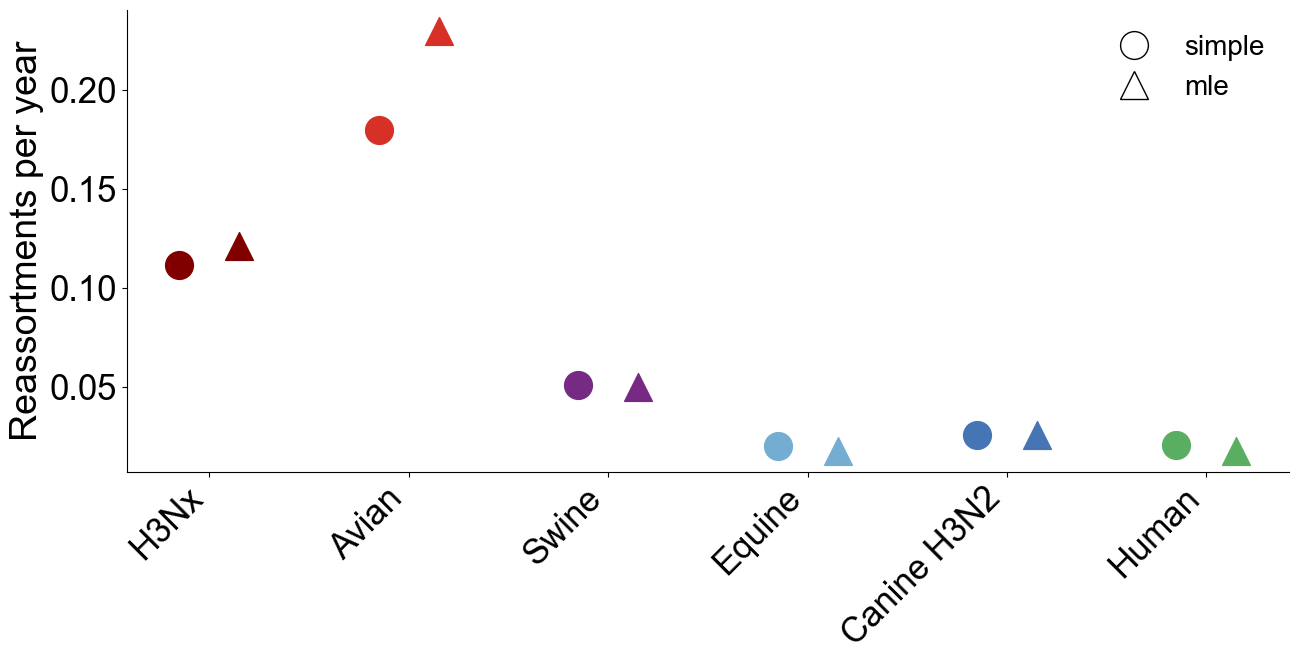

In [67]:
#major host lineages

#both simple and mle on the same plot

est1_data = {
    'H3Nx': est1,
    'Avian': hosts_est1["Avian"],
    'Swine': hosts_est1["Swine"],
    'Equine': hosts_est1["Equine"],
    'Canine H3N2': hosts_est1["Canine"],
    'Human': hosts_est1["Human"]
}

est2_data = {
    'H3Nx': est2,
    'Avian': hosts_est2["Avian"],
    'Swine': hosts_est2["Swine"],
    'Equine': hosts_est2["Equine"],
    'Canine H3N2': hosts_est2["Canine"],
    'Human': hosts_est2["Human"]
}


host_colors = {
    'H3Nx': 'maroon',
    'Avian': '#d73027',
    'Avian Eurasia': '#f46d43',
    'Avian North America': '#fdae61',
    'Swine': '#762a83',
    'Swine North America': '#9970ab' ,
    'Swine Europe' : '#c2a5cf',
    'Equine': '#74add1',
    'Canine H3N2': '#4575b4',
    'Human': '#5aae61'
}

x_labels = list(est1_data.keys())
y_values_est1 = list(est1_data.values())
y_values_est2 = list(est2_data.values())
colors = [host_colors[label] for label in x_labels]

plt.rcParams["font.family"] = "Arial"

fig, ax = plt.subplots(figsize=(15, 6))

for i, label in enumerate(x_labels):
    ax.scatter(i - 0.15, y_values_est1[i], color=colors[i], marker='o', s=400, label=f"{label} (est1)")

for i, label in enumerate(x_labels):
    ax.scatter(i + 0.15, y_values_est2[i], color=colors[i], marker='^', s=400, label=f"{label} (est2)")


ax.set_ylabel('Reassortments per year', fontsize=27)

ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(axis='x', labelsize=25)  
ax.tick_params(axis='y', labelsize=25)

handles = [
    plt.Line2D([0], [0], marker='o', linestyle='None', color='black', markerfacecolor='white', markersize=20, label='simple'),
    plt.Line2D([0], [0], marker='^', linestyle='None', color='black', markerfacecolor='white', markersize=20, label='mle')
]
ax.legend(handles=handles, loc='upper right', frameon=False,
    fontsize=20)

if not os.path.exists("plots/host_rates"):
    os.makedirs("plots/host_rates")
else:
    pass
    
plt.savefig(f"plots/host_rates/host_rates_both.pdf", bbox_inches="tight")

plt.show()
